In [1]:
import os
from matplotlib import pyplot
import numpy as np
import numpy.testing as npt
from scipy.spatial.transform import Rotation
import pickle
import copy
from PIL import Image
from IPython.display import display
from ipywidgets import interact
import ipywidgets as widgets
from torch.utils.data import Subset
import h5py
import time
import cv2
import tqdm
import pprint

In [2]:
from facenet_pytorch import MTCNN
import trimesh
import pyrender

In [5]:
import sys

In [3]:
from trackertraincode.facemodel.bfm import BFMModel
from trackertraincode.facemodel import keypoints68
from trackertraincode.datatransformation import _ensure_image_nchw
from trackertraincode.datasets.dshdf5pose import Hdf5PoseDataset
from trackertraincode.datasets.dshdf5 import open_dataset
from trackertraincode import vis
from trackertraincode import utils
import trackertraincode.datatransformation as dtr
from trackertraincode.datasets.preprocessing import imencode, ImageFormat
from scripts.filter_dataset import filter_file_by_frames
import face3drotationaugmentation

In [7]:
filename = os.path.join(os.environ['DATADIR'],'wflw_train.h5')

In [8]:
def set_field_for_has_exactly_one_face(filename):
    mtcnn = MTCNN(keep_all=True, device='cpu', min_face_size = 32)
    ds = Hdf5PoseDataset(filename, monochrome=False, transform=dtr.to_numpy, whitelist=['/images'])
    mask = np.zeros((len(ds),), dtype='?')
    for i, sample in enumerate(tqdm.tqdm(ds)):
        myboxes, probs = mtcnn.detect(Image.fromarray(sample['image']))
        if len(probs) != 1:
            continue
        mask[i] = True
    ds.close()
    with h5py.File(filename,'r+') as f:
        ds = f.require_dataset('has_one_face', shape=mask.shape, dtype=mask.dtype)
        ds[...] = mask

In [9]:
# Enable if "has_one_face" dataset is not yet present in the hdf5
#set_field_for_has_exactly_one_face(filename)

In [10]:
with h5py.File(filename,'r') as f:
    N = len(f['2dfit_v2/quats'])
    g = f['2dfit_v2']
    h = f['pseudolabels']
    pt2d_68 = f['pt2d_68'][...]
    rois = f['rois'][...].astype(np.float64)
    pred_offline = g['pt3d_68'][...]
    pred_nn = h['pt3d_68'][:N,...]
    quats_offline = g['quats'][:N,...]
    quats_nn = h['quats'][:N,...]
    coords_offline = g['coords'][:N,...]
    coords_nn = h['coords'][:N,...]
    shapeparam_offline = g['shapeparams'][:N,...]
    shapeparam_nn = h['shapeparams'][:N,...]
    has_one_face = f['has_one_face'][...]

In [11]:
#rot_magnitudes_offline = Rotation.from_quat(quats_offline).magnitude()
rot_magnitudes_offline = np.abs(utils.as_hpb(Rotation.from_quat(quats_offline))[:,0])
mask_small_rotation = rot_magnitudes_offline < np.pi/180.*0.
mask_large_rotation = rot_magnitudes_offline > np.pi/180.*90.
mask_rotations = ~(mask_small_rotation | mask_large_rotation)
diameters = np.linalg.norm(rois[:,[2,3]]-rois[:,[0,1]],axis=-1)

delta = np.linalg.norm(quats_offline - quats_nn, axis=-1) + np.linalg.norm(coords_offline - coords_nn,axis=-1)*100./diameters + np.average(np.linalg.norm(pred_nn - pred_offline, axis=-1)*0.5, axis=-1)

In [12]:
def candidates_for_bad_fits():
    # Bad = nn and offline fit are in good agreement except for the jaw on one side where the agreement must be bad.
    not_chin = list(set(range(68)).difference(set(keypoints68.chin_left+keypoints68.chin_right)))
    delta_nn = np.linalg.norm(pt2d_68 - pred_nn[:,:,:2], axis=-1)
    delta_offline = np.linalg.norm(pt2d_68 - pred_offline[:,:,:2], axis=-1)
    delta_chin_nn = delta_nn[:,keypoints68.chin_left+keypoints68.chin_right]
    delta_chin_offline = delta_offline[:,keypoints68.chin_left+keypoints68.chin_right]
    bad_mask1 = np.average(delta_chin_nn, axis=-1) > np.average(delta_chin_offline, axis=-1) + diameters*0.02
    bad_mask2 = np.average(delta_offline, axis=-1) < diameters * 0.1
    bad_mask3 = np.average(delta_nn[:,not_chin], axis=-1) < diameters * 0.1
    return bad_mask1 & bad_mask2 & bad_mask3

In [13]:
np.count_nonzero(candidates_for_bad_fits())

859

In [14]:
mask = mask_rotations & (candidates_for_bad_fits()) & has_one_face
order = np.nonzero(mask)[0]

In [15]:
len(order)

746

In [16]:
order = order[np.argsort(delta[order])]

In [17]:
#bad_sequences = bad_sequences.union(order)

In [18]:
#order = np.setdiff1d(order, list(bad_sequences))

In [19]:
facerender = vis.FaceRender()

In [20]:
ds = Hdf5PoseDataset(filename, monochrome=False, transform=dtr.to_numpy)

In [21]:
# TODO: bad_frames ...

# These are the frames I identified as bad fits. Thus they shall not be used.
bad_sequences = {2, 3, 4, 6, 11, 14, 15, 19, 20, 22, 25, 30, 34, 38, 42, 44, 46, 49, 56, 57, 58,
 61, 66, 70, 77, 78, 81, 85, 92, 97, 100, 101, 102, 106, 107, 109, 110, 111,
 113, 115, 122, 124, 126, 127, 130, 134, 135, 136, 146, 150, 154, 159, 166, 174,
 177, 178, 182, 185, 186, 191, 193, 196, 201, 202, 206, 212, 213, 214, 216, 220,
 221, 222, 224, 228, 229, 230, 231, 232, 234, 247, 248, 253, 254, 259, 260, 266,
 268, 269, 271, 272, 274, 275, 278, 279, 283, 288, 296, 297, 300, 302, 304, 306,
 308, 310, 314, 324, 325, 326, 328, 329, 331, 334, 337, 339, 342, 343, 345, 348,
 349, 350, 354, 356, 359, 367, 369, 370, 373, 378, 384, 386, 387, 389, 390, 391,
 394, 396, 399, 400, 401, 402, 404, 407, 410, 411, 412, 418, 419, 421, 426, 428,
 441, 442, 444, 448, 454, 455, 456, 458, 459, 461, 465, 480, 483, 484, 487, 488,
 496, 506, 509, 513, 514, 519, 521, 524, 525, 527, 528, 532, 537, 542, 550, 551,
 553, 554, 558, 567, 569, 572, 573, 581, 582, 584, 585, 588, 590, 591, 592, 594,
 596, 597, 599, 602, 604, 605, 606, 607, 609, 620, 623, 624, 625, 633, 636, 637,
 640, 644, 646, 649, 653, 656, 657, 658, 664, 666, 671, 675, 676, 677, 681, 684,
 685, 686, 689, 693, 694, 696, 700, 702, 703, 705, 706, 709, 711, 712, 713, 716,
 721, 722, 725, 726, 727, 732, 733, 735, 740, 743, 746, 747, 748, 753, 754, 756,
 757, 764, 765, 770, 772, 773, 774, 775, 777, 783, 784, 788, 791, 792, 793, 794,
 797, 800, 802, 805, 807, 808, 811, 821, 829, 834, 839, 840, 842, 843, 844, 845,
 848, 850, 851, 854, 855, 856, 859, 861, 864, 869, 870, 871, 875, 883, 885, 886,
 888, 894, 896, 897, 899, 901, 902, 906, 922, 925, 937, 938, 939, 940, 941, 942,
 944, 949, 951, 953, 955, 957, 965, 966, 967, 971, 972, 973, 978, 981, 983, 988,
 990, 994, 996, 997, 999, 1000, 1001, 1002, 1010, 1013, 1014, 1016, 1017, 1018,
 1021, 1023, 1025, 1031, 1032, 1035, 1036, 1038, 1041, 1044, 1045, 1048, 1050,
 1051, 1063, 1064, 1066, 1068, 1069, 1070, 1071, 1075, 1077, 1079, 1083, 1085,
 1086, 1090, 1091, 1096, 1097, 1099, 1101, 1105, 1118, 1119, 1123, 1126, 1137,
 1140, 1141, 1146, 1147, 1149, 1152, 1158, 1161, 1166, 1170, 1171, 1175, 1183,
 1184, 1190, 1194, 1197, 1199, 1204, 1206, 1207, 1210, 1216, 1218, 1219, 1222,
 1226, 1229, 1230, 1236, 1239, 1242, 1243, 1245, 1248, 1251, 1256, 1257, 1264,
 1266, 1268, 1269, 1276, 1282, 1283, 1284, 1285, 1287, 1292, 1295, 1297, 1304,
 1305, 1318, 1322, 1326, 1329, 1335, 1341, 1344, 1346, 1349, 1350, 1357, 1359,
 1360, 1361, 1362, 1364, 1367, 1368, 1372, 1375, 1380, 1382, 1383, 1385, 1386,
 1388, 1390, 1394, 1395, 1397, 1398, 1405, 1411, 1415, 1417, 1419, 1422, 1425,
 1426, 1427, 1429, 1439, 1443, 1447, 1451, 1452, 1461, 1462, 1467, 1471, 1474,
 1484, 1486, 1489, 1494, 1498, 1506, 1507, 1508, 1509, 1510, 1515, 1519, 1520,
 1530, 1535, 1536, 1537, 1540, 1544, 1552, 1554, 1556, 1559, 1561, 1562, 1564,
 1567, 1569, 1572, 1573, 1576, 1577, 1580, 1583, 1584, 1587, 1588, 1589, 1593,
 1595, 1600, 1605, 1606, 1609, 1610, 1611, 1614, 1615, 1617, 1620, 1622, 1627,
 1631, 1635, 1639, 1642, 1647, 1648, 1655, 1661, 1662, 1668, 1674, 1675, 1678,
 1679, 1681, 1692, 1693, 1702, 1704, 1706, 1714, 1717, 1722, 1727, 1728, 1730,
 1732, 1734, 1736, 1738, 1748, 1752, 1756, 1763, 1765, 1766, 1770, 1771, 1772,
 1773, 1775, 1779, 1782, 1787, 1789, 1794, 1796, 1798, 1811, 1814, 1815, 1817,
 1819, 1820, 1822, 1824, 1825, 1826, 1828, 1837, 1841, 1843, 1847, 1852, 1860,
 1861, 1862, 1868, 1875, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1894,
 1896, 1897, 1900, 1906, 1911, 1913, 1915, 1917, 1921, 1922, 1924, 1925, 1926,
 1930, 1932, 1934, 1938, 1940, 1947, 1955, 1956, 1960, 1963, 1965, 1966, 1968,
 1973, 1974, 1979, 1982, 1990, 1991, 1994, 1998, 1999, 2000, 2003, 2008, 2012,
 2017, 2019, 2020, 2021, 2029, 2031, 2034, 2038, 2043, 2051, 2054, 2059, 2064,
 2065, 2066, 2075, 2077, 2081, 2083, 2084, 2087, 2089, 2090, 2096, 2098, 2099,
 2101, 2103, 2104, 2109, 2110, 2118, 2120, 2121, 2123, 2127, 2130, 2142, 2145,
 2146, 2150, 2152, 2157, 2158, 2159, 2162, 2165, 2166, 2169, 2170, 2174, 2175,
 2177, 2179, 2183, 2184, 2191, 2194, 2196, 2198, 2201, 2204, 2206, 2208, 2209,
 2212, 2216, 2218, 2219, 2221, 2222, 2224, 2232, 2236, 2240, 2242, 2251, 2253,
 2254, 2260, 2262, 2267, 2273, 2276, 2277, 2285, 2291, 2293, 2295, 2297, 2299,
 2300, 2305, 2306, 2310, 2311, 2315, 2318, 2319, 2322, 2324, 2328, 2329, 2332,
 2339, 2348, 2353, 2354, 2358, 2359, 2361, 2363, 2364, 2367, 2369, 2371, 2378,
 2380, 2381, 2384, 2388, 2389, 2391, 2396, 2401, 2406, 2407, 2408, 2409, 2410,
 2411, 2412, 2413, 2416, 2418, 2422, 2428, 2438, 2439, 2440, 2444, 2446, 2449,
 2451, 2452, 2456, 2458, 2467, 2468, 2469, 2470, 2473, 2476, 2480, 2481, 2482,
 2484, 2485, 2489, 2490, 2492, 2493, 2494, 2497, 2498, 2499, 2502, 2505, 2506,
 2507, 2508, 2509, 2512, 2515, 2519, 2525, 2526, 2528, 2534, 2535, 2536, 2539,
 2540, 2542, 2551, 2552, 2557, 2559, 2560, 2561, 2562, 2565, 2566, 2570, 2571,
 2572, 2573, 2577, 2579, 2580, 2584, 2585, 2588, 2591, 2592, 2593, 2599, 2600,
 2602, 2607, 2609, 2610, 2617, 2618, 2620, 2623, 2625, 2627, 2628}

# TODO: actually use these predictions instead of offline fits.
indices_use_nn_prediction = set()  # Default is offline fit

In [22]:
button = widgets.Button(description='Bad')
button_use_nn_pred = widgets.Button(description='Use NN')
button_use_offline_pred = widgets.Button(description='Use Offline')
button_next = widgets.Button(description='Next')
button_prev = widgets.Button(description='Prev')
slider = widgets.IntSlider(value = 0, min=0, max=len(order)-1)
image_widget = widgets.Image()

label = widgets.Label("---")


my_widgets = widgets.HBox([button_prev, slider, button_next, button, button_use_nn_pred, button_use_offline_pred, label])


current_index = 0


def on_next(_):
    global slider
    slider.value += 1 if slider.value < slider.max else 0
    #update_label()
    #render_sample(current_index)

    
def on_prev(_):
    global slider
    slider.value -= 1 if slider.value > slider.min else 0
    #update_label()
    #render_sample(current_index)
    

def on_button_clicked(_):
    bad_sequences.add(current_index)
    try:
        indices_use_nn_prediction.remove(current_index)
    except KeyError:
        pass
    update_label()


def on_button_use_nn_pred(_):
    try:
        bad_sequences.remove(current_index)
    except KeyError:
        pass
    indices_use_nn_prediction.add(current_index)
    update_label()

    
def on_button_use_offline_pred(_):
    try:
        bad_sequences.remove(current_index)
    except KeyError:
        pass
    try:
        indices_use_nn_prediction.remove(current_index)
    except KeyError:
        pass
    update_label()


def update_label():
    if current_index in bad_sequences:
        label.value = f"Bad Label {current_index}"
        return
    if current_index in indices_use_nn_prediction:
        label.value = f"NN {current_index}"
        return
    label.value = f"Offline {current_index}"

def value_changed(change):
    render_sample(change.new)
    
button.on_click(on_button_clicked)
button_use_nn_pred.on_click(on_button_use_nn_pred)
button_use_offline_pred.on_click(on_button_use_offline_pred)
button_prev.on_click(on_prev)
button_next.on_click(on_next)
slider.observe(value_changed, 'value')


display(my_widgets)
display(image_widget)

def _visualize(sample):
    img = sample['image']
    rendering = facerender.set(
        sample['coord'][:2],
        sample['coord'][2],
        Rotation.from_quat(sample['pose']),
        sample['shapeparam'][:50],
        img.shape[:2],
    )
    sample = copy.copy(sample)
    rendering = Image.fromarray(rendering)
    img = Image.fromarray(img)
    img = Image.blend(rendering, img, 0.4)
    sample['image'] = np.asarray(img)
    img = vis.draw_dataset_sample(sample)
    return img


#@interact(idx = (0,len(order)-1))
def render_sample(idx): #, overlay, show_network_prediction):
    i = order[idx]
    sample_image = ds[i]['image']
    h, w = sample_image.shape[:2]    
    
    global current_index
    current_index = i
    
    img = sample_image
    if img.shape[-1] == 1:
        img = np.broadcast_to(img, img.shape[:2]+(3,))
    
    nn_sample = {
        'image' : np.asarray(img),
        'coord' : coords_nn[i],
        'pose' : quats_nn[i],
        'pt3d_68' : pred_nn[i],
        'shapeparam' : shapeparam_nn[i],
    }

    offline_sample = {
        'image' : np.asarray(img),
        'coord' : coords_offline[i],
        'pose' : quats_offline[i],
        'pt3d_68' : pred_offline[i],
        'shapeparam' : shapeparam_offline[i],
    }
    
    vis.draw_points3d(
        img,
        ds[i]['pt2d_68'],
        labels=False
    )
    nn_vis = _visualize(nn_sample)
    nn_vis = cv2.putText(nn_vis, 'nn', (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    offline_vis = _visualize(offline_sample)
    offline_vis = cv2.putText(offline_vis, 'offline', (15,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    img = np.r_['1,1,1',img,nn_vis,offline_vis]
    
    if i in bad_sequences:
        linewidth = 2
        color = (255,0,0)
        cv2.line(img, (0,0), (img.shape[1],img.shape[0]), color, linewidth)
        cv2.line(img, (0,img.shape[0]), (img.shape[1],0), color, linewidth)
    
    update_label()
    
    #return my_widgets
    #display(Image.fromarray(img))
    image_widget.value = imencode(img,ImageFormat.PNG)

Image(value=b'')

In [23]:
pprint.pprint(bad_sequences,compact=True)
pprint.pprint(indices_use_nn_prediction,compact=True)

{2, 3, 4, 6, 11, 14, 15, 19, 20, 22, 25, 30, 34, 38, 42, 44, 46, 49, 56, 57, 58,
 61, 66, 70, 77, 78, 81, 85, 92, 97, 100, 101, 102, 106, 107, 109, 110, 111,
 113, 115, 122, 124, 126, 127, 130, 134, 135, 136, 146, 150, 154, 159, 166, 174,
 177, 178, 182, 185, 186, 191, 193, 196, 201, 202, 206, 212, 213, 214, 216, 220,
 221, 222, 224, 228, 229, 230, 231, 232, 234, 247, 248, 253, 254, 259, 260, 266,
 268, 269, 271, 272, 274, 275, 278, 279, 283, 288, 296, 297, 300, 302, 304, 306,
 308, 310, 314, 324, 325, 326, 328, 329, 331, 334, 337, 339, 342, 343, 345, 348,
 349, 350, 354, 356, 359, 367, 369, 370, 373, 378, 384, 386, 387, 389, 390, 391,
 394, 396, 399, 400, 401, 402, 404, 407, 410, 411, 412, 418, 419, 421, 426, 428,
 441, 442, 444, 448, 454, 455, 456, 458, 459, 461, 465, 480, 483, 484, 487, 488,
 496, 506, 509, 513, 514, 519, 521, 524, 525, 527, 528, 532, 537, 542, 550, 551,
 553, 554, 558, 567, 569, 572, 573, 581, 582, 584, 585, 588, 590, 591, 592, 594,
 596, 597, 599, 602, 604, 605, 6

In [24]:
good_indices = np.setdiff1d(np.arange(N), bad_sequences)

In [25]:
len(good_indices)

2629

In [26]:
good_indices_file = 'wflw_train_indices_for_3d_rot_aug_v3.txt'
augmented_filename = os.path.join(os.environ['DATADIR'],'wflw_augmented_v3.h5')
filename = os.path.join(os.environ['DATADIR'],'wflw_train.h5')
# Temporary data
destination = os.path.join('/tmp','wflw_train_w_offline_fits.h5')
filtered_destination = os.path.join('/tmp','wflw_train_good_fitted_frontal_faces.h5')

In [27]:
with open(os.path.join(os.environ['DATADIR'],good_indices_file),'w',encoding='utf-8') as f:
    f.write(','.join(map(str,good_indices)))

In [28]:
#with open(os.path.join(os.environ['DATADIR'],good_indices_file),'r',encoding='utf-8') as f:
#    good_indices = np.array([int(x) for x in f.read().split(',')])

In [29]:
with h5py.File(filename, 'r') as f_input, h5py.File(destination, 'w') as f_output:
    from_to = [
        ('images','images'),
        ('rois','rois'),
        ('2dfit_v2/quats','quats'),
        ('2dfit_v2/coords','coords'),
        ('2dfit_v2/pt3d_68','pt3d_68'),
        ('2dfit_v2/shapeparams','shapeparams'),
    ]
    for from_, to in from_to:
        f_input.copy(from_, f_output, to)
with h5py.File(destination, 'r') as f_output, h5py.File(filtered_destination, 'w') as f_filtered:
    filter_file_by_frames(f_output, f_filtered,good_frame_indices=good_indices)

In [32]:
def as_rotaug_sample(sample):
    fields = dict(sample)
    fields['rot'] = Rotation.from_quat(fields.pop('pose'))
    xys = fields.pop('coord')
    fields['xy'] = xys[:2]
    fields['scale'] = xys[2]
    fields['image'] = np.asarray(fields.pop('image'))
    return fields

In [33]:
rng = np.random.RandomState(seed=12345678)

In [34]:
augds = Hdf5PoseDataset(filtered_destination, transform=dtr.to_numpy, monochrome=False)

In [35]:
visualizer = face3drotationaugmentation.SampleVisualizerWindow()

0it [00:00, ?it/s]Using cache found in /home/mwelter/.cache/torch/hub/intel-isl_MiDaS_1645b7e1675301fdfac03640738fe5a6531e17d6
/opt/conda-env/ml/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/mwelter/.cache/torch/hub/intel-isl_MiDaS_1645b7e1675301fdfac03640738fe5a6531e17d6
2it [00:10,  4.72s/it]

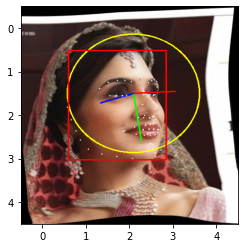

2629it [1:11:42,  1.64s/it]


In [36]:
with face3drotationaugmentation.dataset_writer(augmented_filename) as writer:
    for i, sample in enumerate(tqdm.tqdm(map(as_rotaug_sample, augds))):
        gen = face3drotationaugmentation.augment_sample(rng=rng, angle_step=5., prob_closed_eyes=0.5, prob_spotlight=0.001, sample=sample)
        name  = f'sample{i:02d}'
        del sample['index']
        writer.write(name, sample)
        for new_sample in gen:
            if np.random.randint(0,100)==0:
                visualizer.show(new_sample)
            pyplot.pause(0.001)
            writer.write(name,new_sample)